In [100]:
import pandas
import cv2
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from keras_preprocessing.image import ImageDataGenerator
from scipy import stats
from collections import defaultdict
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [31]:
SEG_IMG_PATHS = ["../Results/Final/Lateral/Segmented Characters/Exactly 7",
                 "../Results/Final/mat_españolas/Segmented Characters/Exactly 7"]
THRESHOLD = 127
WINDOW_SIZE = 1000
LABELS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
          'B', 'C', 'D', 'F', 'G', 'H', 'J', 'K', 'L', 'M',
          'N', 'P', 'R', 'S', 'T', 'V', 'W', 'X', 'Y', 'Z']


In [20]:
def rename_files(dir_path):
    for filename in os.listdir(dir_path):
        full_path = os.path.join(dir_path, filename)
        name, extension = os.path.splitext(filename)
        new_filename = name[-1] + extension
        new_path = os.path.join(dir_path, new_filename)
        os.rename(full_path, new_path)

#rename_files(PATH_TO_ORIGINAL_IMAGE_DIRECTORY)

In [21]:
def show_image_on_window(image: np.array, window_name: str = "Image") -> None:
    scale = max(image.shape[:2]) / WINDOW_SIZE
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(window_name, int(
        image.shape[1] // scale), int(image.shape[0] // scale))
    cv2.imshow(window_name, image)
    cv2.waitKey(3000)
    cv2.destroyWindow(window_name)

In [22]:
def adapt_image(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, image_binary = cv2.threshold(image, THRESHOLD, 255, cv2.THRESH_BINARY)
    if image_binary.shape != (22,36):
        image_binary = cv2.resize(image_binary, (22,36))
    return image_binary/255

In [23]:
def load_images(dir_path):
        images = []
        chars = []
        filenames = []
        for file_name in os.listdir(dir_path):
                name, extension = os.path.splitext(file_name)
                if extension == ".png":
                        original_image = cv2.imread(dir_path + "/" + file_name)
                        binary_image = adapt_image(original_image)
                        images.append(binary_image)
                        chars.append(name)
                        filenames.append(file_name)
        return np.array(images), np.array(chars), filenames

DATA AUGMENTATION

In [24]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.05,
    fill_mode='nearest'
)
#X = np.expand_dims(X, axis=-1)
#datagen.fit(X)

In [24]:
def gen_aug_images(X, y, dir_path, num_aug_img=100):
    tag_count = {}
    
    for image, tag in zip(X, y):
        tag_str = str(tag)
        if tag_str not in tag_count:
            tag_count[tag_str] = 0
        image = np.expand_dims(image, axis=0)
        i = 0
        for batch in datagen.flow(image, batch_size=1):
            tag_count[tag_str] += 1
            filename = f"{tag_str}_{tag_count[tag_str]}.png"
            full_path = os.path.join(dir_path, filename)
            bin_img = (batch[0] > 0.5).astype(np.uint8) * 255
            cv2.imwrite(full_path, bin_img)
            i += 1
            if i >= num_aug_img:
                break 


#gen_aug_images(X, Y, PATH_TO_ORIGINAL_IMAGE_DIRECTORY)


### SVM MODEL ###

In [93]:
def load_data_svm(dir_paths):
    images = []
    chars = []

    for dir_path in dir_paths:
        for root, _, files in os.walk(dir_path):
            for file_name in files:
                name, extension = os.path.splitext(file_name)
                if extension == ".png" or extension == ".jpg":
                    full_path = os.path.join(root, file_name)
                    original_image = cv2.imread(full_path)
                    binary_image = adapt_image(original_image)
                    #bianry_image = binary_image.flatten()
                    images.append(binary_image)
                    chars.append(name[-2])

    return np.array(images), np.array(chars)


In [94]:
# El generador para aumentar imágenes
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.05,
    fill_mode='nearest'
)

def augment_images_to_target(images_by_category, target_count=100):
    augmented_images = []
    augmented_labels = []

    for label, images in images_by_category.items():
        num_images = len(images)

        # Si ya hay suficientes imágenes, no hacemos nada
        if num_images >= target_count:
            augmented_images.extend(images[:target_count])
            augmented_labels.extend([label] * target_count)
        else:
            # Generamos más imágenes hasta llegar al target_count
            images_to_add = target_count - num_images
            images_np = np.array(images)  # Convertimos las imágenes a numpy array para aumentar
            images_np = np.expand_dims(images_np, axis=-1)

            # Creamos un flujo de imágenes con el generador
            i = 0
            for x in datagen.flow(images_np, batch_size=1):
                augmented_images.append(np.squeeze(x[0], axis=-1))  # Agregamos la imagen generada
                augmented_labels.append(label)
                i += 1
                if i >= images_to_add:
                    break  # Romper cuando tengamos suficientes imágenes

            # Añadimos las imágenes originales también
            augmented_images.extend(images)
            augmented_labels.extend([label] * num_images)

    return np.array(augmented_images), np.array(augmented_labels)


def split_data_per_category(X, y, test_size=10, augment=False, max_images_per_class=100):
    # Organizar las imágenes por clase
    images_by_category = defaultdict(list)
    for image, label in zip(X, y):
        images_by_category[label].append(image)

    # Inicializar conjuntos de entrenamiento y test
    X_train = []
    X_test = []
    y_train = []
    y_test = []

    # Dividir por cada categoría en train y test
    for label, images in images_by_category.items():
        images = np.array(images)
        
        # Asegurarse de que hay suficientes imágenes para test
        if len(images) < test_size:
            raise ValueError(f"No hay suficientes imágenes para la categoría '{label}' para crear el conjunto de test con {test_size} imágenes. Solo hay {len(images)} imágenes disponibles.")
        
        # Dividimos manualmente en test y train asegurándonos de que test tenga `test_size` imágenes
        X_test_cat = images[:test_size]
        X_train_cat = images[test_size:]

        y_test_cat = [label] * len(X_test_cat)
        y_train_cat = [label] * len(X_train_cat)
        
        # Añadir los datos a las listas globales
        X_train.extend(X_train_cat)
        y_train.extend(y_train_cat)
        X_test.extend(X_test_cat)
        y_test.extend(y_test_cat)

    # Convertir las listas en arrays numpy
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Si augment es True, aumentar el conjunto de entrenamiento
    if augment:
        # Reorganizamos las imágenes de entrenamiento por clase para la aumentación
        images_by_category_train = defaultdict(list)
        for image, label in zip(X_train, y_train):
            images_by_category_train[label].append(image)
        
        # Llamar a la función para aumentar los datos
        X_train_augmented, y_train_augmented = augment_images_to_target(images_by_category_train, target_count=max_images_per_class)
        
        X_train_augmented = X_train_augmented.reshape(X_train_augmented.shape[0], -1)
        X_test = X_test.reshape(X_test.shape[0], -1)
        
        return X_train_augmented, X_test, y_train_augmented, y_test
    
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    
    return X_train, X_test, y_train, y_test


In [102]:
X, y = load_data_svm(SEG_IMG_PATHS)

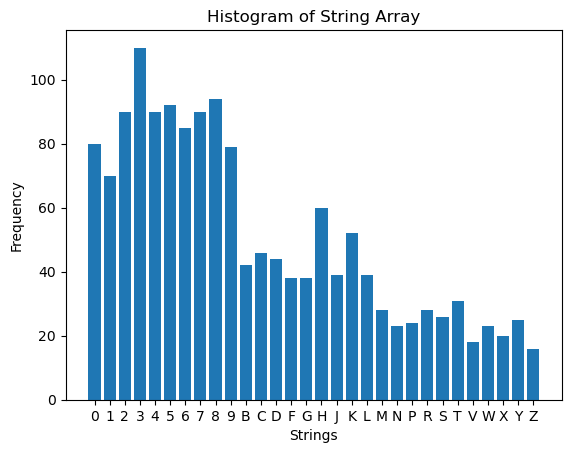

In [96]:
unique_strings, counts = np.unique(y, return_counts=True)

plt.bar(unique_strings, counts)
plt.xlabel('Strings')
plt.ylabel('Frequency')
plt.title('Histogram of String Array')
plt.show()

In [97]:
X_train, X_test, y_train, y_test = split_data_per_category(X, y, test_size=10, augment=True, max_images_per_class=200)

print(len(X_train), len(y_train))
print(len(X_test), len(y_test))
print(X_test.shape)

6000 6000
300 300
(300, 792)


WITH AUGMENTED DATA

In [98]:
svm_model = SVC(kernel='rbf') 
svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.33%


In [44]:
with open('svm_model.pkl', 'wb') as file:
    pickle.dump(svm_model, file)

In [ ]:
#with open('svm_model.pkl', 'rb') as file:
#    loaded_model = pickle.load(file)

Mean accuracy: 95.45%
95% confidence interval: (93.79%, 97.12%)


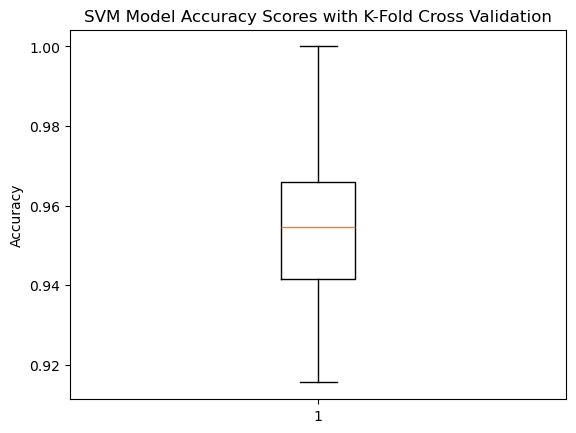

In [91]:
svm_model = SVC(kernel='rbf')

X = X.reshape(X.shape[0], -1)

scores = cross_val_score(svm_model, X, y, cv=10, scoring='accuracy')

confidence_interval = stats.t.interval(0.95, len(scores)-1, loc=np.mean(scores), scale=stats.sem(scores))

print(f"Mean accuracy: {np.mean(scores) * 100:.2f}%")
print(f"95% confidence interval: ({confidence_interval[0] * 100:.2f}%, {confidence_interval[1] * 100:.2f}%)")

plt.boxplot(scores)
plt.title('SVM Model Accuracy Scores with K-Fold Cross Validation')
plt.ylabel('Accuracy')
plt.show()

In [42]:
print(scores)

[0.96103896 0.95454545 0.94155844 0.97402597 0.95454545 0.96753247
 1.         0.91558442 0.94155844 0.93506494]


In [103]:
def conf_mat(y, y_pred):
    class_labels = np.unique(y)
    conf_matrix = confusion_matrix(y, y_pred)

    # Mostrar la matriz de confusión como un heatmap con las etiquetas personalizadas
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels, cbar=False)  # cbar=False para eliminar la escala de color

    # Girar las etiquetas del eje Y a horizontal
    plt.yticks(rotation=0)

    # Etiquetas y título
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix from Cross-Validation')
    plt.show()

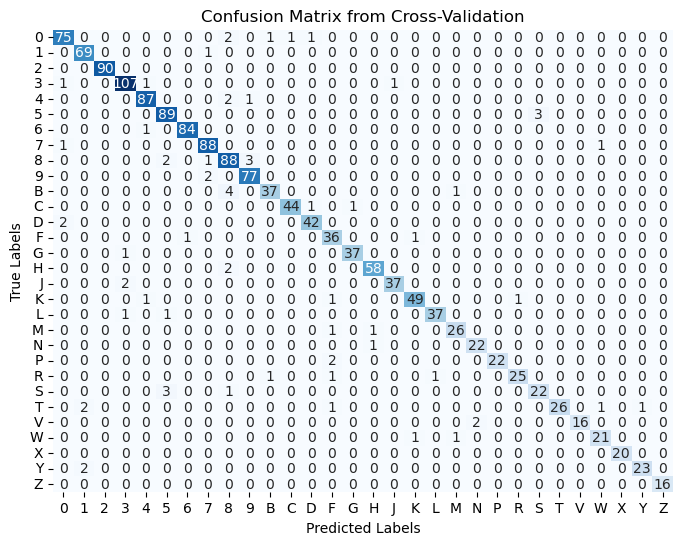

In [105]:
# Generar las predicciones usando cross-validation
kf = StratifiedKFold(n_splits=10)
X = X.reshape(X.shape[0], -1)
y_pred = cross_val_predict(svm_model, X, y, cv=kf)

conf_mat(y, y_pred)


!

!

ELIMINAR ARCHIVOS

In [3]:
def eliminar_png_largos(direccion_carpeta):
    # Recorre todos los archivos en la carpeta dada
    for archivo in os.listdir(direccion_carpeta):
        ruta_completa = os.path.join(direccion_carpeta, archivo)
        
        # Verifica si es un archivo (no directorio)
        if os.path.isfile(ruta_completa):
            # Obtiene el nombre del archivo sin la extensión y su extensión
            nombre_archivo, extension = os.path.splitext(archivo)
            
            # Comprueba si la extensión es '.png' y si el nombre tiene 7 o más caracteres
            if extension == '.png' and len(nombre_archivo) >= 3:
                # Elimina el archivo
                os.remove(ruta_completa)

#eliminar_png_largos(PATH_TO_ORIGINAL_IMAGE_DIRECTORY)
